# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV30"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv30')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv30/lv30-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 13:47:49,060 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
160,DMAP_ERY3,30,0.949372,2.606235e-55,5.621648e-52
161,DMAP_ERY4,30,0.983727,4.892627e-54,5.276698e-51
162,DMAP_ERY5,30,0.975559,2.727078e-52,1.960769e-49


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP035312, SRP034711, SRP056295, SRP036133, SRP022133, SRP050260, SRP059172, SRP015138, SRP055513, SRP046233, SRP032775, SRP063834, SRP012461, SRP050272, SRP051675, SRP015439, SRP041988, SRP063493, SRP063477, SRP033266, SRP003227, SRP048759, SRP005281, SRP061689, SRP050000, SRP056840, SRP058654, SRP050493, SRP050333, SRP007947, SRP014620, SRP057196, SRP033135, SRP036843, SRP018028, SRP059039, SRP055569, SRP057500, SRP066151, SRP009247, SRP041751, SRP009862, SRP060416, SRP045500, SRP007338, SRP049820, SRP024244, SRP052874, SRP050499, SRP066834, SRP002326, SRP029990, SRP047192, SRP062966, SRP018403, SRP050440, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (55 != 56)
  warnings.warn(


In [19]:
lv_data.shape

(6979, 98)

In [20]:
lv_data.head()

strain      tissue  \
project   run                                            
SRP035312 SRR1106084  Cultured CD34+ cells  Cord blood   
          SRR1106085  Cultured CD34+ cells  Cord blood   
          SRR1106087  Cultured CD34+ cells  Cord blood   
          SRR1106086  Cultured CD34+ cells  Cord blood   
          SRR1106089  Cultured CD34+ cells  Cord blood   

                     surface markers to isolate cells by facs-based methods  \
project   run                                                                 
SRP035312 SRR1106084  GPA low, Band3 negative and alpha 4 integrin high       
          SRR1106085  GPA low, Band3 negative and alpha 4 integrin high       
          SRR1106087  GPA positive, Band3 medium and alpha 4 integri...       
          SRR1106086  GPA low, Band3 negative and alpha 4 integrin high       
          SRR1106089  GPA positive, Band3 medium and alpha 4 integri...       

                                          cell type differentiation stage  \
project   run                                                               
SRP035312 SRR1106084                proerythroblast                   NaN   
          SRR1106085                proerythroblast                   NaN   
          SRR1106087  early basophilic erythroblast                   NaN   
          SRR1106086                proerythroblast                   NaN   
          SRR1106089  early basophilic erythroblast                   NaN   

                     cell composition differentiation day time  age  \
project   run                                                         
SRP035312 SRR1106084              NaN                 NaN  NaN  NaN   
          SRR1106085              NaN                 NaN  NaN  NaN   
          SRR1106087              NaN                 NaN  NaN  NaN   
          SRR1106086              NaN                 NaN  NaN  NaN   
          SRR1106089              NaN                 NaN  NaN  NaN   

                     developmental stage  ... time in culture Stage diagnosis  \
project   run                             ...                                   
SRP035312 SRR1106084                 NaN  ...             NaN   NaN       NaN   
          SRR1106085                 NaN  ...             NaN   NaN       NaN   
          SRR1106087                 NaN  ...             NaN   NaN       NaN   
          SRR1106086                 NaN  ...             NaN   NaN       NaN   
          SRR1106089                 NaN  ...             NaN   NaN       NaN   

                     pre- or post-challenge disease status anti-ro  ism  \
project   run                                                             
SRP035312 SRR1106084                    NaN            NaN     NaN  NaN   
          SRR1106085                    NaN            NaN     NaN  NaN   
          SRR1106087                    NaN            NaN     NaN  NaN   
          SRR1106086                    NaN            NaN     NaN  NaN   
          SRR1106089                    NaN            NaN     NaN  NaN   

                     genotype/variation activation      LV30  
project   run                                                 
SRP035312 SRR1106084                NaN        NaN  0.214689  
          SRR1106085                NaN        NaN  0.219089  
          SRR1106087                NaN        NaN  0.559072  
          SRR1106086                NaN        NaN  0.184955  
          SRR1106089                NaN        NaN  0.331750  

[5 rows x 98 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

strain                                                    1.944459
surface markers to isolate cells by facs-based methods    1.944459
differentiation stage                                     1.503909
cell composition                                          0.231068
differentiation day                                       0.231068
time                                                      0.079236
resonse to decitabine                                     0.063021
cytogenetics                                              0.055360
type of chronic myelomonocytic leukemia                   0.055360
mutation                                                  0.055360
time in culture                                           0.044977
cell sorted                                               0.044977
condition                                                 0.036404
disease state                                             0.030029
tissue                                                    0.02

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

tissue       0.029866
cell type    0.023700
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "differentiation stage",
        "tissue",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[0]

cell type  \
project   run                                                   
SRP035312 SRR1106097              orthochromatic erythroblast   
SRP034711 SRR1057987                                      NaN   
          SRR1057992                                      NaN   
SRP035312 SRR1106098              orthochromatic erythroblast   
          SRR1106096              orthochromatic erythroblast   
SRP034711 SRR1057982                                      NaN   
          SRR1057991                                      NaN   
SRP035312 SRR1106095               polychromatic erythroblast   
SRP034711 SRR1057986                                      NaN   
SRP035312 SRR1106094               polychromatic erythroblast   
          SRR1106093               polychromatic erythroblast   
SRP034711 SRR1057981                                      NaN   
SRP056295 SRR1918550       acute myeloid leukemia (AML) cells   
          SRR1918549       acute myeloid leukemia (AML) cells   
SRP036133 SRR1153284  in vitro differentiated erythroid cells   
SRP035312 SRR1106090             late basophilic erythroblast   
SRP034711 SRR1057980                                      NaN   
SRP022133 SRR846955                                       NaN   
SRP050260 SRR1663125                                      NaN   
          SRR1663126                                      NaN   
SRP059172 SRR2052794                                      NaN   
SRP036133 SRR1153281  in vitro differentiated erythroid cells   
SRP015138 SRR547607       primary CD34+ stem/progenitor cells   
SRP055513 SRR1818514                                      NaN   
SRP046233 SRR1566098   bone marrow mononuclear cells (BM MNC)   

                                  differentiation stage             tissue  \
project   run                                                                
SRP035312 SRR1106097                                NaN         Cord blood   
SRP034711 SRR1057987  orthochromatophilic erythroblasts                NaN   
          SRR1057992  orthochromatophilic erythroblasts                NaN   
SRP035312 SRR1106098                                NaN         Cord blood   
          SRR1106096                                NaN         Cord blood   
SRP034711 SRR1057982  orthochromatophilic erythroblasts                NaN   
          SRR1057991   polychromatophilic erythroblasts                NaN   
SRP035312 SRR1106095                                NaN         Cord blood   
SRP034711 SRR1057986   polychromatophilic erythroblasts                NaN   
SRP035312 SRR1106094                                NaN         Cord blood   
          SRR1106093                                NaN         Cord blood   
SRP034711 SRR1057981   polychromatophilic erythroblasts                NaN   
SRP056295 SRR1918550                                NaN  Heparinised blood   
          SRR1918549                                NaN  Heparinised blood   
SRP036133 SRR1153284                                NaN                NaN   
SRP035312 SRR1106090                                NaN         Cord blood   
SRP034711 SRR1057980      late basophilic erythroblasts                NaN   
SRP022133 SRR846955                                 NaN        whole blood   
SRP050260 SRR1663125                                NaN              liver   
          SRR1663126                                NaN              liver   
SRP059172 SRR2052794                                NaN        Whole blood   
SRP036133 SRR1153281                                NaN                NaN   
SRP015138 SRR547607                                 NaN                NaN   
SRP055513 SRR1818514                                NaN              liver   
SRP046233 SRR1566098                                NaN                NaN   

                          LV30  
project   run                   
SRP035312 SRR1106097  3.904820  
SRP034711 SRR1057987  3.896084  
          SRR1057992  3.716563  
SRP035312 SRR1106098  3.

In [26]:
# what is there in these projects?
lv_data.loc[["SRP063493"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

treatment cell line disease state sf3b1 mutation  \
project   run                                                           
SRP063493 SRR2313081       NaN       NaN           MDS          K700E   
          SRR2313087       NaN       NaN           MDS          K700E   
          SRR2313079       NaN       NaN           MDS          E622D   
          SRR2313080       NaN       NaN           MDS          E622D   
          SRR2313082       NaN       NaN           MDS          K700E   
          SRR2313076       NaN       NaN           MDS          K700E   
          SRR2313088       NaN       NaN           MDS          E622D   
          SRR2313083       NaN       NaN           MDS          K700E   
          SRR2313098       CHX    Nalm-6           NaN            NaN   
          SRR2313070       NaN       NaN           CLL            NaN   

                          LV30  
project   run                   
SRP063493 SRR2313081  0.608661  
          SRR2313087  0.550191  
          SRR2313079  0.327609  
          SRR2313080  0.268452  
          SRR2313082  0.244418  
          SRR2313076  0.172439  
          SRR2313088  0.153668  
          SRR2313083  0.090227  
          SRR2313098  0.026439  
          SRR2313070  0.025800

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["differentiation stage", "tissue"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type      LV30
project   run                                                          
SRP035312 SRR1106097              orthochromatic erythroblast  3.904820
SRP034711 SRR1057987        orthochromatophilic erythroblasts  3.896084
          SRR1057992        orthochromatophilic erythroblasts  3.716563
SRP035312 SRR1106098              orthochromatic erythroblast  3.702319
          SRR1106096              orthochromatic erythroblast  3.026069
SRP034711 SRR1057982        orthochromatophilic erythroblasts  3.022507
          SRR1057991         polychromatophilic erythroblasts  2.991272
SRP035312 SRR1106095               polychromatic erythroblast  2.982417
SRP034711 SRR1057986         polychromatophilic erythroblasts  2.791095
SRP035312 SRR1106094               polychromatic erythroblast  2.790727
          SRR1106093               polychromatic erythroblast  2.464357
SRP034711 SRR1057981         polychromatophilic erythroblasts  2.463199
SRP056295 SRR1918550       acute myeloid leukemia (AML) cells  1.343758
          SRR1918549       acute myeloid leukemia (AML) cells  1.342473
SRP036133 SRR1153284  in vitro differentiated erythroid cells  1.288435
SRP035312 SRR1106090             late basophilic erythroblast  1.172599
SRP034711 SRR1057980            late basophilic erythroblasts  1.170231
SRP022133 SRR846955                               whole blood  1.131776
SRP050260 SRR1663125                                    liver  1.119884
          SRR1663126                                    liver  1.093241

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            #             "adipocyte": "Adipocytes",
        }
    }
)

In [34]:
# all samples from SRP049593 are fibroblasts
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: "Erythroblast cells" if x.name[0] in ("SRP005281",) else x["cell type"],
    axis=1,
)

In [35]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [36]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [37]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

25

In [40]:
attr_order[:5]

['orthochromatophilic erythroblasts',
 'orthochromatic erythroblast',
 'polychromatophilic erythroblasts',
 'polychromatic erythroblast',
 'acute myeloid leukemia (AML) cells']

## Plot

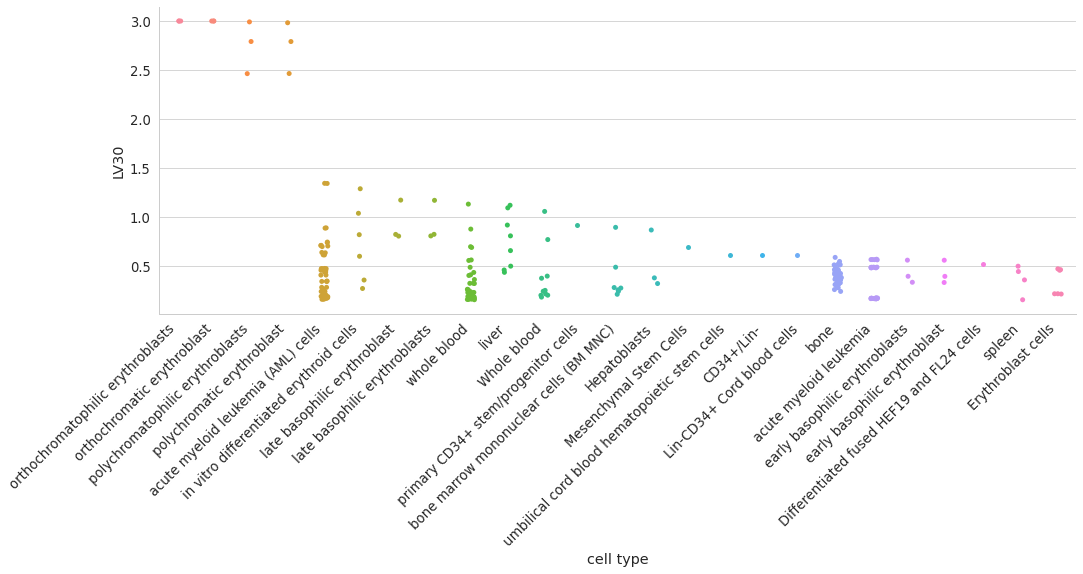

In [41]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [42]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("NOT CAT")]
#     display(_tmp.head(20))

In [43]:
# # what is there in these projects?
# lv_data.loc[["SRP050499"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)